# Загрузка данных из Kaggle
Выполняется для загрузки файлов!

Для выполнения требуется Kaggle API Token.
Инструкция (пунтк 7): https://towardsdatascience.com/7-ways-to-load-external-data-into-google-colab-7ba73e7d5fc7

In [ ]:
!pwd

/content


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle competitions download -c dog-breed-identification

 99% 681M/691M [00:03<00:00, 172MB/s]
100% 691M/691M [00:03<00:00, 192MB/s]


In [ ]:
!unzip /content/dog-breed-identification.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/841463629c4833816e216cbb041c2778.jpg  
  in

# Подготовка данных 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_theme()
tf.__version__

'2.8.0'

## Предварительный анализ данных
### Размер, форма и распределение


>>> ID <<<

0        000bec180eb18c7604dcecc8fe0dba07.jpg
1        001513dfcb2ffafc82cccf4d8bbaba97.jpg
2        001cdf01b096e06d78e9e5112d419397.jpg
3        00214f311d5d2247d5dfe4fe24b2303d.jpg
4        0021f9ceb3235effd7fcde7f7538ed62.jpg
                         ...                 
10217    ffd25009d635cfd16e793503ac5edef0.jpg
10218    ffd3f636f7f379c51ba3648a9ff8254f.jpg
10219    ffe2ca6c940cddfee68fa3cc6c63213f.jpg
10220    ffe5f6d8e2bff356e9482a80a6e29aac.jpg
10221    fff43b07992508bc822f33d8ffd902ae.jpg
Name: id, Length: 10222, dtype: object


>>> Breeds <<<

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64





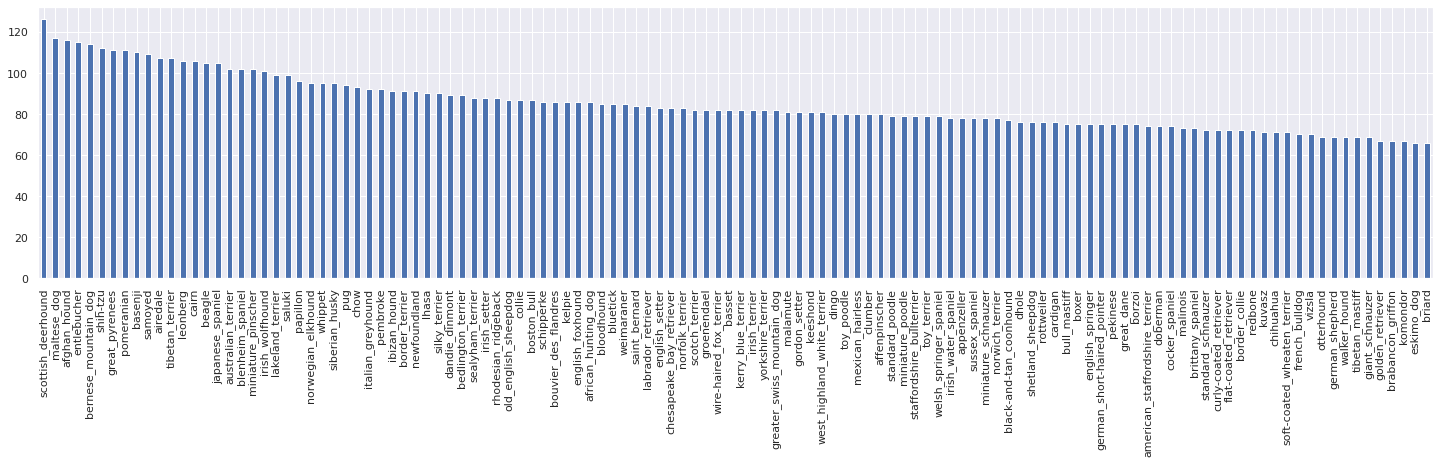

In [ ]:
labels_df = pd.read_csv('labels.csv')
labels_df['id'] = labels_df['id'] + '.jpg'
print("\n>>> ID <<<\n")
print(labels_df.id)
print("\n\n>>> Breeds <<<\n")
print(labels_df.breed.value_counts())
print("\n\n")
labels_df.breed.value_counts().plot.bar(figsize=(25, 5));

In [ ]:
datagen = ImageDataGenerator(rescale=1.0 / 255,
                             horizontal_flip=True,
                             vertical_flip=True,
                             shear_range=0.2,
                             validation_split=0.1)

train = datagen.flow_from_dataframe(labels_df,
                                    directory='train',
                                    x_col='id',
                                    y_col='breed',
                                    subset='training',
                                    target_size=(224, 224),
                                    batch_size=64,
                                    seed=123)

val = datagen.flow_from_dataframe(labels_df,
                                  directory='train',
                                  x_col='id',
                                  y_col='breed',
                                  subset='validation',
                                  target_size=(224, 224),
                                  batch_size=64,
                                  seed=123)

Found 9200 validated image filenames belonging to 120 classes.
Found 1022 validated image filenames belonging to 120 classes.


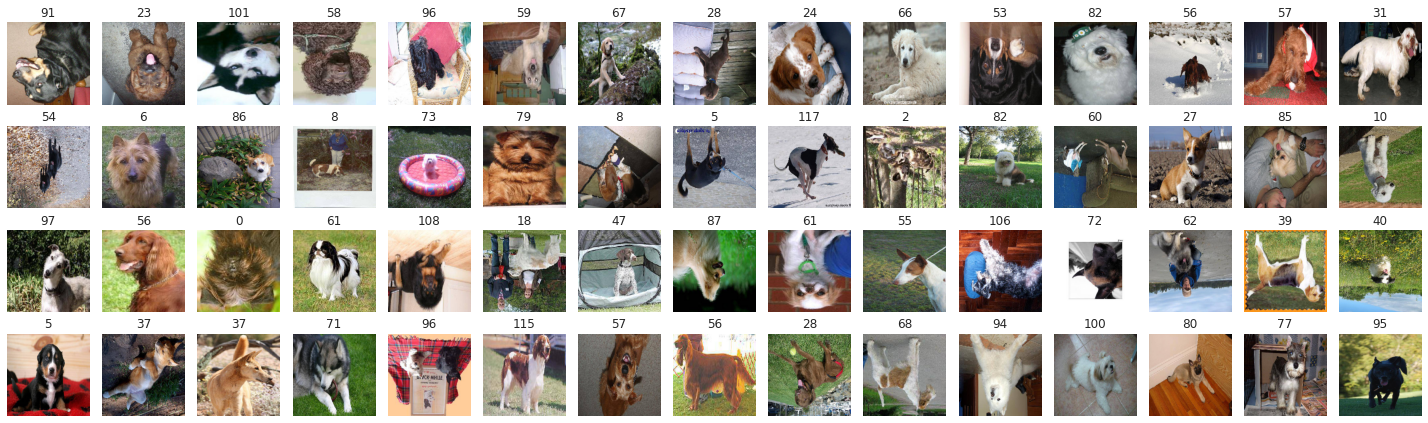

In [ ]:
# Get the images from a val batch
imgs = val.next()
labels = list(val.class_indices.keys())

plt.figure(figsize=(20, 6))
cols, rows = 15, 4
for i in range(cols * rows):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[0][i])
    plt.title(np.argmax(imgs[1][i]))
    plt.axis('off')

plt.tight_layout();

# Начало обучения
Взял из интернета рандомный метод для пробы https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/5

Выполняется один проход:
 - в среднем за 40 минут без ускорителя
 - также 40 минут с TPU
 - за 2 минуты с подключенным GPU

В будущем будем использовать другой, более приземленный метод

Есть что-то похожее по методу https://www.kaggle.com/code/aryaadesh/dog-breed-classification

In [ ]:
url_resnet = 'https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/5'
url_vgg = 'https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1'
url_inception = 'https://tfhub.dev/google/imagenet/inception_v3/classification/5'
url_rn = 'https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5'
inception_resnet = tf.keras.Sequential([
    hub.KerasLayer(url_rn, trainable=False),
    tf.keras.layers.Dense(120, activation='softmax'),
    ])
inception_resnet.build((None, 224, 224, 3)) #inceptionresnet
#inception_resnet.build((None, 32, 32, 3)) #vgg
inception_resnet.compile(loss='categorical_crossentropy',
                         optimizer='adam', metrics=['accuracy'])
h = inception_resnet.fit(train, validation_data=val, epochs=10,
                         steps_per_epoch=len(train),
                         validation_steps=len(val))

Epoch 1/10
144/144 [==============================] - 176s 1s/step - loss: 3.2094 - accuracy: 0.3389 - val_loss: 2.1952 - val_accuracy: 0.4530
Epoch 2/10
144/144 [==============================] - 162s 1s/step - loss: 1.7667 - accuracy: 0.5377 - val_loss: 2.0567 - val_accuracy: 0.4873
Epoch 3/10
144/144 [==============================] - 163s 1s/step - loss: 1.5059 - accuracy: 0.6067 - val_loss: 2.0826 - val_accuracy: 0.5020
Epoch 4/10
144/144 [==============================] - 163s 1s/step - loss: 1.3533 - accuracy: 0.6403 - val_loss: 2.0930 - val_accuracy: 0.5029
Epoch 5/10
144/144 [==============================] - 162s 1s/step - loss: 1.2135 - accuracy: 0.6635 - val_loss: 2.0039 - val_accuracy: 0.5333
Epoch 6/10
144/144 [==============================] - 162s 1s/step - loss: 1.1405 - accuracy: 0.6810 - val_loss: 2.0811 - val_accuracy: 0.5225
Epoch 7/10
144/144 [==============================] - 160s 1s/step - loss: 1.0652 - accuracy: 0.6962 - val_loss: 2.1445 - val_accuracy: 0.5342

## Prediction and Submission

In [ ]:
test_df = pd.read_csv('sample_submission.csv')
breeds = test_df.columns[1:].tolist()
test_df['file_name'] = test_df['id'] + '.jpg'

In [ ]:
test_gen = ImageDataGenerator(rescale=1.0 / 255)

test = test_gen.flow_from_dataframe(test_df,
                                    x_col='file_name',
                                    y_col=None,
                                    directory='test',
                                    class_mode=None,
                                    target=(224, 224))

Found 10357 validated image filenames.


In [ ]:
# Predict (~00:01:20)
test_df.loc[:, breeds] = inception_resnet.predict(test)
test_df[breeds].head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,0.000073,0.000049,1.026599e-06,2.231287e-06,1.993795e-06,1.685396e-05,3.239549e-04,9.893979e-07,0.000014,7.826162e-07,...,2.319305e-05,9.964159e-06,3.818068e-05,2.292157e-07,2.889435e-07,1.987601e-08,1.225678e-04,1.063649e-06,6.855349e-06,0.000328
1,0.000009,0.000007,6.486281e-06,7.493499e-03,1.635537e-04,2.059754e-05,1.029118e-06,1.461738e-05,0.000004,1.133205e-05,...,2.998340e-05,9.996334e-07,1.251814e-06,1.132524e-04,1.177708e-06,8.498484e-07,1.600826e-04,2.111666e-04,4.596308e-01,0.000005
2,0.000259,0.000077,5.356753e-08,3.178314e-08,6.973219e-09,1.067613e-07,2.153163e-05,3.564991e-09,0.000034,1.399932e-08,...,7.068076e-06,6.784252e-08,5.594543e-07,2.396387e-08,6.779282e-07,6.991821e-10,7.590777e-07,5.185243e-08,3.334069e-07,0.000324
3,0.000004,0.002742,5.809546e-05,4.014751e-03,9.385165e-08,8.800050e-03,4.435645e-04,2.196245e-08,0.000008,3.942758e-07,...,8.752955e-09,5.078399e-09,1.530932e-04,4.654003e-06,3.746389e-06,9.226622e-06,3.733222e-06,1.226792e-06,3.828200e-07,0.000216
4,0.000086,0.000009,2.420775e-06,2.631279e-04,1.341068e-02,1.162289e-02,5.634077e-08,3.299983e-02,0.002972,6.336854e-04,...,2.574157e-05,4.598695e-02,2.096630e-07,2.928401e-06,7.951167e-06,8.874552e-06,4.700793e-04,3.253913e-02,1.865392e-08,0.000147


In [ ]:
test_df.drop('file_name', axis=1).to_csv('submission.csv', index=False)